In [1]:
import random
import pandas as pd 
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

path = "C:/Users/GMRIT/Desktop/nitish_529/PlantVillage"

print(path)

DATASET_DIR = r'C:/Users/GMRIT/Desktop/nitish_529/PlantVillage'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

datagen = ImageDataGenerator(rescale=1./255)
all_data_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

filenames = all_data_gen.filepaths
classes = all_data_gen.classes
class_labels = list(all_data_gen.class_indices.keys())

data = pd.DataFrame({
    'filename': filenames,
    'class': [class_labels[k] for k in classes]
})

train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['class'], random_state=SEED)
val_data, test_data = train_test_split(test_data, test_size=0.5, stratify=test_data['class'], random_state=SEED)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)



C:/Users/GMRIT/Desktop/nitish_529/PlantVillage
Found 20638 images belonging to 15 classes.
Found 16510 validated image filenames belonging to 15 classes.
Found 2064 validated image filenames belonging to 15 classes.
Found 2064 validated image filenames belonging to 15 classes.


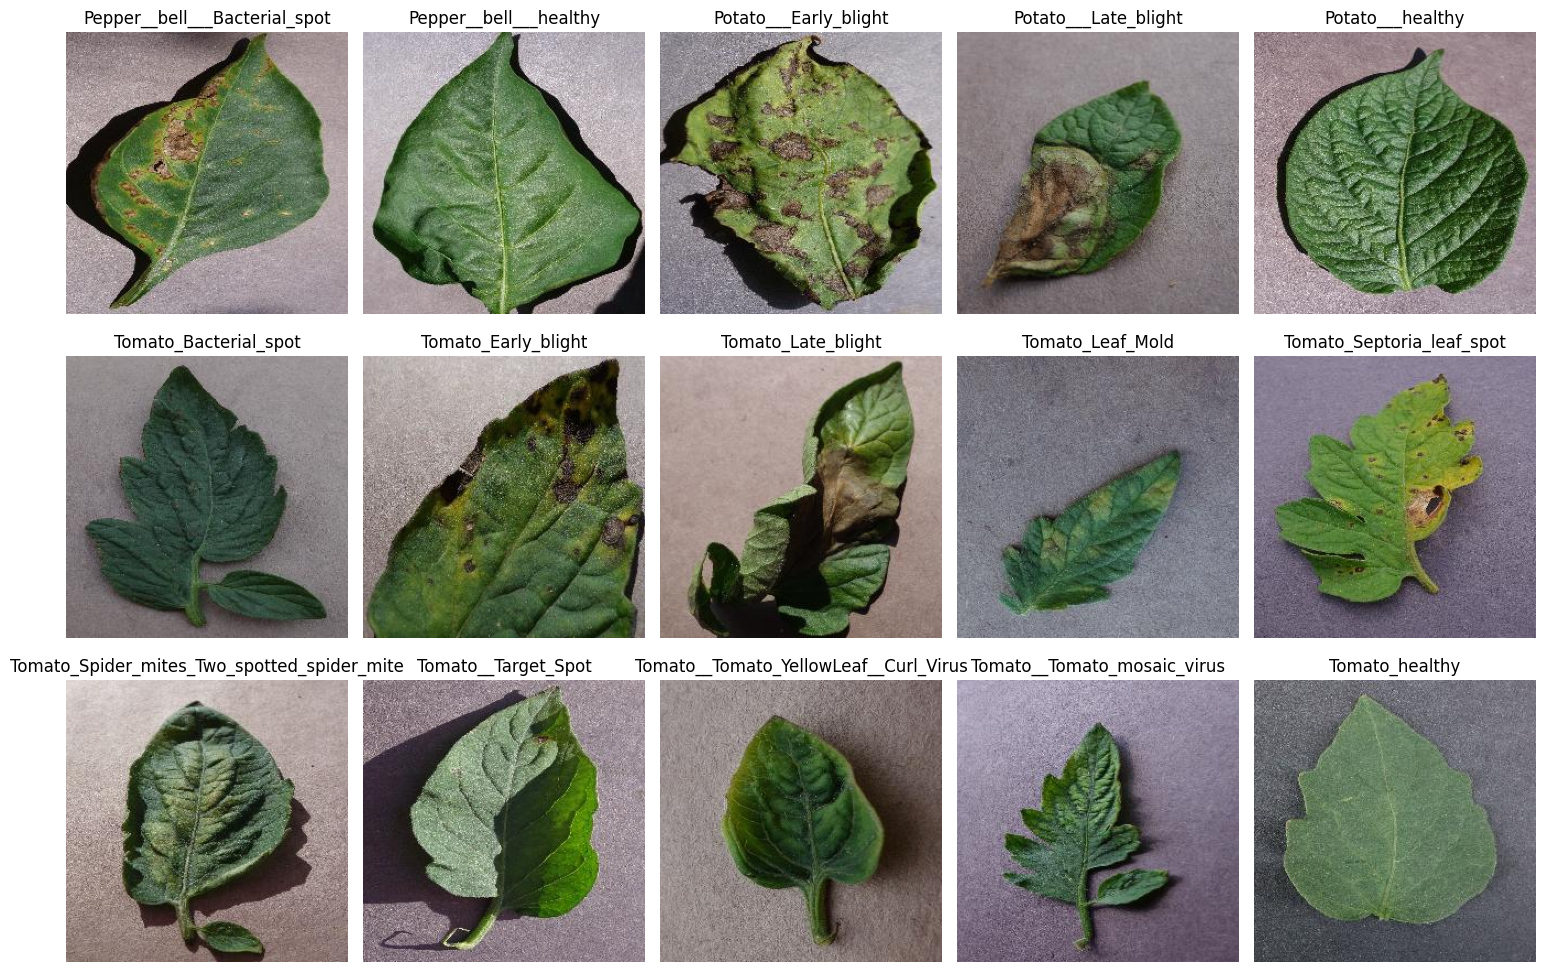

In [3]:
import matplotlib.pyplot as plt
import cv2
import os

# Dictionary to store one example file per class
example_images = {}

# Loop through filenames and find the first occurrence of each class
for _, row in data.iterrows():
    class_name = row['class']
    if class_name not in example_images:
        example_images[class_name] = row['filename']
    if len(example_images) == len(class_labels):
        break  # Stop once we have one image for each class

# Create the figure
plt.figure(figsize=(15, 10), facecolor='white')

# Plot one image per class
for i, (class_name, img_path) in enumerate(example_images.items()):
    plt.subplot(3, 5, i + 1)  # Adjust grid based on number of classes (3 rows, 5 cols = 15 classes)

    img = cv2.imread(img_path)
    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title(class_name, fontsize=12)
        plt.axis('off')
    else:
        print(f"Error loading image from {img_path}")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the ResNet152V2 model with pre-trained ImageNet weights
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model to prevent them from being trained
base_model.trainable = False

# Add custom top layers to the ResNet model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    layers.Dense(15, activation='softmax')  # Change the number of classes (10 here as an example)
])

# Compile the model with an Adam optimizer and categorical crossentropy loss
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 15)                15375     
                                                                 
Total params: 60,445,199
Trainable params: 2,113,551
Non-trainable params: 58,331,648
__________________________________

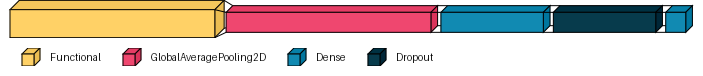

<Figure size 1500x1000 with 0 Axes>

In [7]:
plt.figure(figsize=(15,10),facecolor="white")
import visualkeras
visualkeras.layered_view(model,legend=True)

In [8]:
#early stopping and callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_resnet152v2_model.keras', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/50
516/516 [==============================] - 259s 492ms/step - loss: 1.0899 - accuracy: 0.6575 - val_loss: 0.5516 - val_accuracy: 0.8290
Epoch 2/50
516/516 [==============================] - 117s 226ms/step - loss: 0.5356 - accuracy: 0.8246 - val_loss: 0.3970 - val_accuracy: 0.8828
Epoch 3/50
516/516 [==============================] - 117s 226ms/step - loss: 0.4020 - accuracy: 0.8710 - val_loss: 0.3345 - val_accuracy: 0.8929
Epoch 4/50
516/516 [==============================] - 116s 226ms/step - loss: 0.3176 - accuracy: 0.8967 - val_loss: 0.3049 - val_accuracy: 0.9026
Epoch 5/50
516/516 [==============================] - 117s 226ms/step - loss: 0.2668 - accuracy: 0.9142 - val_loss: 0.2651 - val_accuracy: 0.9176
Epoch 6/50
516/516 [==============================] - 117s 226ms/step - loss: 0.2302 - accuracy: 0.9273 - val_loss: 0.2552 - val_accuracy: 0.9181
Epoch 7/50
516/516 [==============================] - 140s 271ms/step - loss: 0.1962 - accuracy: 0.9382 - val_loss: 0.2430 -

In [9]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.2f}")

2064/2064 [==============================] - 47s 22ms/step - loss: 0.1723 - accuracy: 0.9443
Test accuracy: 0.94


In [10]:
model.save(r'C:\Users\GMRIT\Desktop\nitish_529\resnet152v2_94.h5')

In [23]:
# Unfreeze only the last N layers of the base model
UNFREEZE_LAYERS = 100  # You can adjust this value based on available memory

# Set all layers to non-trainable by default
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last N layers
for layer in base_model.layers[-UNFREEZE_LAYERS:]:
    layer.trainable = True


In [24]:
from tensorflow.keras.optimizers import Adam

# Re-compile the model after partial unfreezing
model.compile(optimizer=Adam(learning_rate=1e-5),  # Small LR for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print trainable layer count
print(f"Trainable layers: {sum([layer.trainable for layer in model.layers for layer in getattr(layer, 'layers', [layer])])}")


Trainable layers: 104


In [25]:
history_fine_tune = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]  # Reuse your previous callbacks
) 

Epoch 1/10
516/516 [==============================] - 166s 309ms/step - loss: 0.1062 - accuracy: 0.9693 - val_loss: 0.1951 - val_accuracy: 0.9385
Epoch 2/10
516/516 [==============================] - 159s 308ms/step - loss: 0.0448 - accuracy: 0.9882 - val_loss: 0.1690 - val_accuracy: 0.9457
Epoch 3/10
516/516 [==============================] - 159s 308ms/step - loss: 0.0195 - accuracy: 0.9963 - val_loss: 0.1668 - val_accuracy: 0.9511
Epoch 4/10
516/516 [==============================] - 193s 374ms/step - loss: 0.0130 - accuracy: 0.9970 - val_loss: 0.1614 - val_accuracy: 0.9511
Epoch 5/10
516/516 [==============================] - 232s 449ms/step - loss: 0.0092 - accuracy: 0.9983 - val_loss: 0.1615 - val_accuracy: 0.9516
Epoch 6/10
516/516 [==============================] - 159s 309ms/step - loss: 0.0079 - accuracy: 0.9984 - val_loss: 0.1648 - val_accuracy: 0.9520
Epoch 7/10
516/516 [==============================] - 191s 370ms/step - loss: 0.0049 - accuracy: 0.9993 - val_loss: 0.1607 -

In [26]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.2f}")

2064/2064 [==============================] - 46s 22ms/step - loss: 0.1544 - accuracy: 0.9617
Test accuracy: 0.96


In [27]:
model.save(r'C:\Users\GMRIT\Desktop\nitish_529\resnet152v2_96.h5')

In [28]:
from tensorflow.keras.models import load_model
model=load_model(r'C:\Users\GMRIT\Desktop\nitish_529\resnet152v2_96.h5')

Total steps (batches to process): 2064
2064/2064 [==============================] - 48s 22ms/step - loss: 0.1544 - accuracy: 0.9617
Test Loss: 0.15439718961715698
Test Accuracy: 0.9617248177528381
1/1 [==============================] - 0s 22ms/step


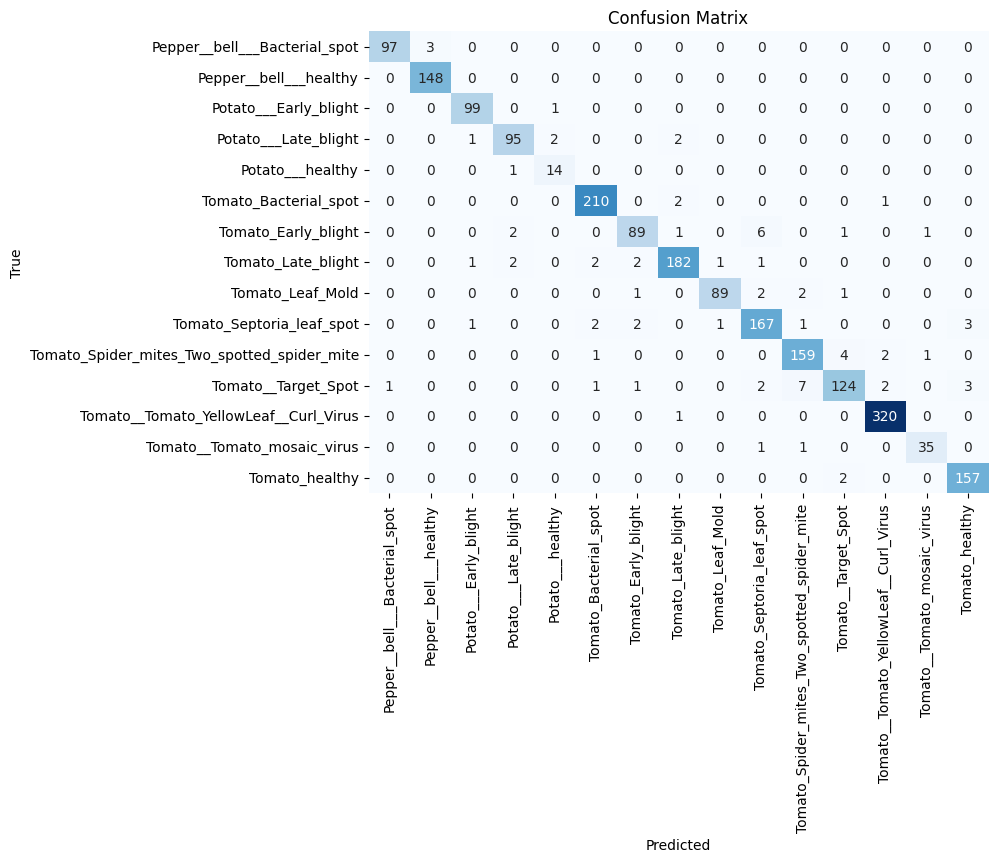

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have these from your trained model
# test_generator: A generator that yields batches of data (X, y)
# model: Your trained Keras/TensorFlow model

# Calculate number of steps based on the number of test images and batch size
steps = np.ceil(test_generator.samples / test_generator.batch_size).astype(int)
print(f"Total steps (batches to process): {steps}")

# Step 1: Evaluate the model on the test generator (optional, if you need to see loss/accuracy)
score = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {score[0]}")
print(f"Test Accuracy: {score[1]}")

# Step 2: Predict the labels on the entire test dataset from the test generator
y_true = []
y_pred = []

# Loop over the test generator and collect the results
for i, (X_batch, y_batch) in enumerate(test_generator):
    y_batch_pred = model.predict(X_batch)  # Get predictions for the batch
    
    y_true.extend(np.argmax(y_batch, axis=1))  # True labels
    y_pred.extend(np.argmax(y_batch_pred, axis=1))  # Predicted labels
    
    # Stop once we have reached the defined number of steps
    if i + 1 >= steps:
        break  # Exit after processing the desired number of batches

# Convert lists to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Step 3: Generate the Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 4: Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import  classification_report, roc_curve, auc
from sklearn.metrics import  f1_score, precision_score, recall_score

In [31]:
precision = precision_score(y_true, y_pred, average='macro')  # Change to 'micro', 'macro', or 'weighted' for multi-class
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Precision: 0.9514
Recall: 0.9543
F1-Score: 0.9524


In [32]:
print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       100
           1       0.98      1.00      0.99       148
           2       0.97      0.99      0.98       100
           3       0.95      0.95      0.95       100
           4       0.82      0.93      0.88        15
           5       0.97      0.99      0.98       213
           6       0.94      0.89      0.91       100
           7       0.97      0.95      0.96       191
           8       0.98      0.94      0.96        95
           9       0.93      0.94      0.94       177
          10       0.94      0.95      0.94       167
          11       0.94      0.88      0.91       141
          12       0.98      1.00      0.99       321
          13       0.95      0.95      0.95        37
          14       0.96      0.99      0.98       159

    accuracy                           0.96      2064
   macro avg       0.95      0.95      0.95      2064
wei

In [33]:
y_prob = model.predict(test_generator, verbose=1)

2064/2064 [==============================] - 42s 20ms/step


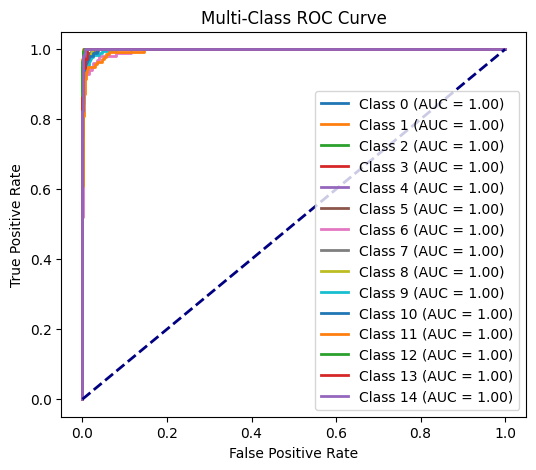

In [34]:
if y_prob.shape[1] > 2:  # Multi-class classification
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(y_prob.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_prob[:, i])  # Binarize for each class
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(6, 5))
    for i in range(len(roc_auc)):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

1/1 [==============================] - 0s 26ms/step


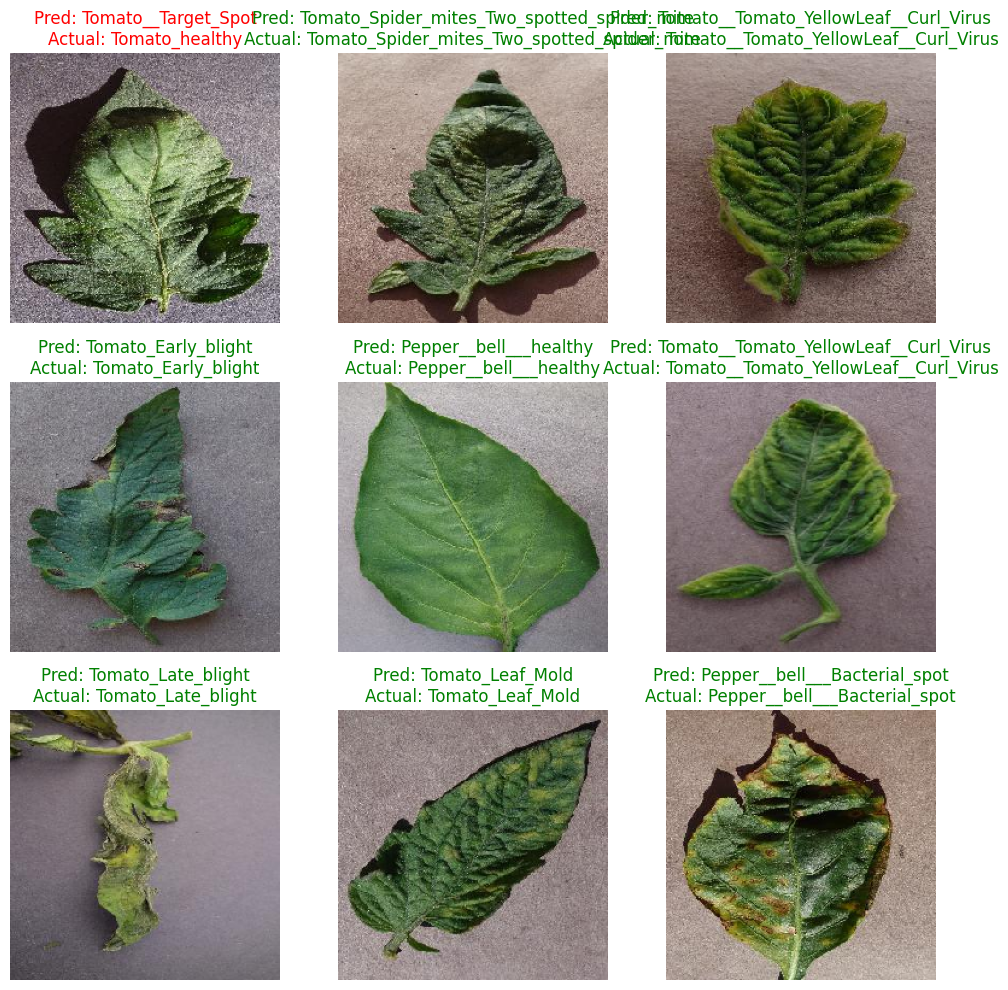

In [35]:
filenames = test_generator.filenames
classes = test_generator.classes
labels = list(test_generator.class_indices.keys())

random_indices = random.sample(range(len(filenames)), 9)
images = []
actual_labels = []
predicted_labels = []

for idx in random_indices:
    img, label = test_generator[idx]
    images.append(img[0])
    actual_labels.append(classes[idx])
    pred = model.predict(img)
    predicted_labels.append(np.argmax(pred))

plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    actual_class = labels[actual_labels[i]]
    predicted_class = labels[predicted_labels[i]]
    color = 'green' if actual_class == predicted_class else 'red'
    plt.title(f"Pred: {predicted_class}\nActual: {actual_class}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [36]:
import gradio as gr
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = tf.keras.models.load_model(r'C:\Users\GMRIT\Desktop\nitish_529\resnet152v2_96.h5')

def predict_rice_disease(img):
    # Preprocess the image to the correct format for the model
    img = img.resize((224, 224))  # Assuming the model expects 224x224 images
    img_array = np.array(img) / 255.0  # Normalize if needed
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction
    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions, axis=-1)[0]  # Get the index of the predicted class
    
    # Map the predicted class index to the disease name (modify according to your class names)
    class_names = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight',  'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight',   'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus',  'Tomato_healthy'] # Example class names
    return class_names[class_idx]
# Create Gradio interface
interface = gr.Interface(
    fn=predict_rice_disease,  # The function to call for predictions
    inputs=gr.Image(type="pil"),  # Input is an image in PIL format
    outputs=gr.Textbox(),  # Output is a text label showing the disease name
    title="Rice Disease Detection",  # Title of the interface
    description="Upload an image of a rice leaf to detect its disease.",  # Description of the app
)

# Launch the interface
interface.launch()


c:\Users\GMRIT\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 33ms/step
